In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import numpy as np
import pandas as pd

import pyro

from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

<IPython.core.display.Javascript object>

In [3]:
import muvi

<IPython.core.display.Javascript object>

In [4]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7f47d2c93ec0>


<IPython.core.display.Javascript object>

In [5]:
# plotting settings
sns.set(rc={"figure.figsize": (11.7, 8.27)})
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context(
    "notebook",
    font_scale=1.5,
    rc={"lines.linewidth": 4},
)



<IPython.core.display.Javascript object>

In [6]:
try:
    gpu_idx = muvi.get_free_gpu_idx()
    print("Using GPU #%s" % gpu_idx)
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)
except Exception as e:
    print(e)

Using GPU #2


<IPython.core.display.Javascript object>

First, lets generate some multi-view synthetic data. The dataset comprises 200 samples and four views, each having 400 features. In addition, the underlying relationships across views consist of 2 factors shared among all views, 14 factors shared among a subset of two or three views, as well as a private factor for each view. Finally, we may introduce additional covariates that can be modelled jointly during training.

In [7]:
seed = 123
n_samples = 200
n_features = [400, 400, 400, 400]
n_views = len(n_features)
likelihoods = ["normal" for _ in range(n_views)]
n_covariates = 2


<IPython.core.display.Javascript object>

In [8]:
dg = muvi.DataGenerator(
    n_samples,
    n_features,
    likelihoods,
    n_covariates=n_covariates,
)

rng = dg.generate(seed=seed, n_comb=4)

# standardise data
dg.normalise(with_std=False)


<IPython.core.display.Javascript object>

In [9]:
feature_offsets = [0] + np.cumsum(n_features).tolist()
vlines = feature_offsets[1:-1]

<IPython.core.display.Javascript object>

<AxesSubplot:>

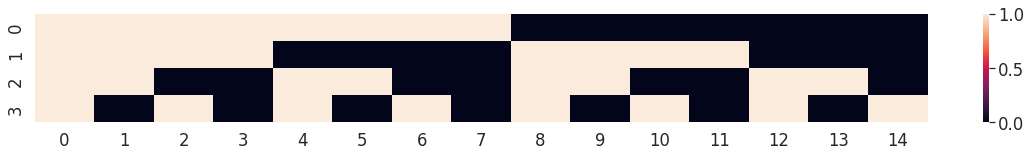

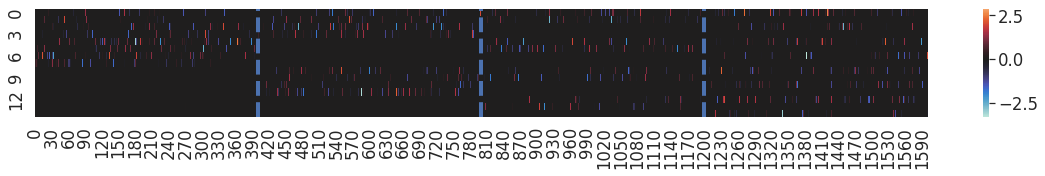

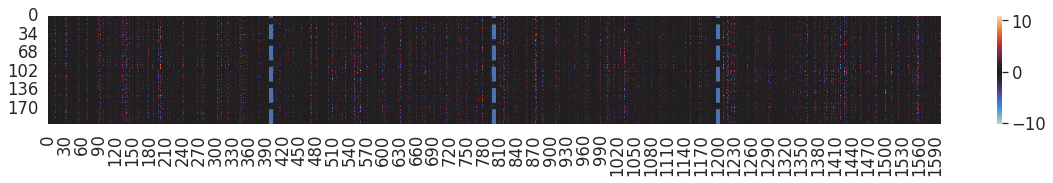

<IPython.core.display.Javascript object>

In [10]:
# factor loadings should be fairly sparse
muvi.pl.lined_heatmap(dg.view_factor_mask)
muvi.pl.lined_heatmap(dg.w, vlines=vlines, center=0)
muvi.pl.lined_heatmap(dg.y, vlines=vlines, center=0)

Now we can perturb the true underlying mask of the factor loadings in order to inform the model noisy feature sets. We do so by introducing false positives and false negatives controlled by a `noise_fraction` parameter. We may also determine which views we would like to inform via `informed_views`, a list of view indices. Here we only inform the first view (index 0).

<AxesSubplot:>

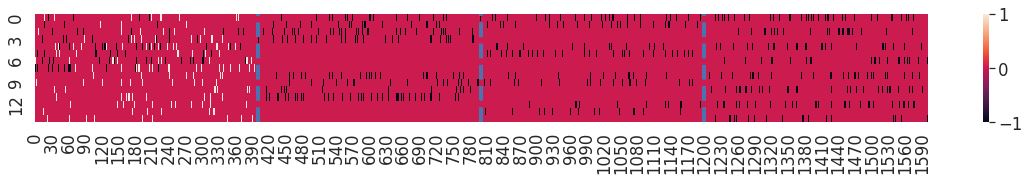

<IPython.core.display.Javascript object>

In [11]:
# perturb
noise_fraction = 0.5
# inform only first view with noisy prior
informed_views = [0]

_ = dg.get_noisy_mask(
    rng,
    noise_fraction=noise_fraction,
    informed_view_indices=informed_views,
)

# false positives and false negatives
muvi.pl.lined_heatmap(dg.noisy_w_mask - dg.w_mask, vlines=vlines)

Now that we generated a noisy version of the true factor loadings mask, we need to inform our model by relaxing the binary prior information to values larger than zero for the slab widths of the regularized horseshoe. We do so by providing a `confidence` that ranges from 0 to 1 when adding the prior mask. The `confidence` encodes our prior belief regarding the (noisy) prior information. A weak belief corresponds to values around 0.95, medium to 0.99 and strong to larger than 0.99 (closer to 1.0). As a rule of thumb, a `confidence` of 0.99 provides the best results on average (default argument).

In [13]:
# create an instance of the model
model = muvi.MuVI(
    dg.ys,
    prior_masks=dg.noisy_w_masks,
    covariates=dg.x,
    seed=seed,
    use_gpu=True,
)

<IPython.core.display.Javascript object>

Now we can train our model via a (stochastic) variational inference algorithm. We may also provide additional callbacks during training such as `EarlyStoppingCallback` for terminating the optimization procedure when the ELBO improvements are insignificant, or `LogCallback` for keeping track of relevant metric scores and how they progress during training.

In [14]:
# set number of iterations
n_iterations = 10000

# this callback logs metrics of the training every X steps to better gauge the training progress
log_callback = muvi.LogCallback(
    model,
    n_iterations,
    n_checkpoints=10,
    # pass true masks
    masks={vn: dg.w_masks[m].astype(bool) for m, vn in enumerate(model.view_names)},
    binary_scores_at=500,
    threshold=0.1,
    log=True,
    log_frequency=10,
    n_annotated=model.n_factors,
    informed_views=informed_views,
)


<IPython.core.display.Javascript object>

In [15]:
# set random seed
pyro.set_rng_seed(seed)

# clean start
print("Cleaning parameter store")
pyro.enable_validation(True)
pyro.clear_param_store()

loss_history, _ = model.fit(
    batch_size=n_samples,
    n_iterations=n_iterations,
    n_particles=20,
    learning_rate=0.01,
    optimizer='clipped',
    verbose=1,
    callbacks=[
        log_callback,
        muvi.EarlyStoppingCallback(
            n_iterations,
            min_iterations=1000,
            window_size=10,
            tolerance=1e-5,
            patience=10,
        )
    ],
)



Cleaning parameter store


  0%|                                                 | 0/10000 [00:00<?, ?it/s]

2022-03-23 21:31:53,274 - root - INFO - Guessed max_plate_nesting = 3


 10%|██▍                     | 1001/10000 [00:41<07:48, 19.21it/s, ELBO=1.15e+3]

Average fraction of inactive loadings:
view_0: 0.952, view_1: 0.976, view_2: 0.978, view_3: 0.974
Binary scores between prior mask and learned activations with a threshold of 0.1 for top 500 (abs) weights:
`view_name`: (prec, rec, f1)
view_0: (0.930, 0.947, 0.938)
RMSE for each view:
view_0: 0.353, view_1: 0.541, view_2: 0.456, view_3: 0.597
Variance explained for each view:
view_0: 0.813, view_1: 0.422, view_2: 0.521, view_3: 0.403


 20%|█████▌                      | 2003/10000 [01:23<05:59, 22.27it/s, ELBO=810]

Average fraction of inactive loadings:
view_0: 0.953, view_1: 0.953, view_2: 0.965, view_3: 0.951
Binary scores between prior mask and learned activations with a threshold of 0.1 for top 500 (abs) weights:
`view_name`: (prec, rec, f1)
view_0: (0.975, 0.986, 0.981)
RMSE for each view:
view_0: 0.320, view_1: 0.340, view_2: 0.339, view_3: 0.374
Variance explained for each view:
view_0: 0.887, view_1: 0.835, view_2: 0.806, view_3: 0.802


 30%|████████▍                   | 3002/10000 [02:04<05:31, 21.13it/s, ELBO=779]

Average fraction of inactive loadings:
view_0: 0.953, view_1: 0.951, view_2: 0.965, view_3: 0.945
Binary scores between prior mask and learned activations with a threshold of 0.1 for top 500 (abs) weights:
`view_name`: (prec, rec, f1)
view_0: (0.993, 0.989, 0.991)
RMSE for each view:
view_0: 0.320, view_1: 0.324, view_2: 0.339, view_3: 0.350
Variance explained for each view:
view_0: 0.886, view_1: 0.878, view_2: 0.806, view_3: 0.843


 40%|███████████▏                | 4001/10000 [02:47<05:07, 19.53it/s, ELBO=759]

Average fraction of inactive loadings:
view_0: 0.953, view_1: 0.951, view_2: 0.964, view_3: 0.943
Binary scores between prior mask and learned activations with a threshold of 0.1 for top 500 (abs) weights:
`view_name`: (prec, rec, f1)
view_0: (0.989, 0.993, 0.991)
RMSE for each view:
view_0: 0.321, view_1: 0.324, view_2: 0.339, view_3: 0.318
Variance explained for each view:
view_0: 0.886, view_1: 0.878, view_2: 0.805, view_3: 0.903


 47%|█████████████               | 4670/10000 [03:16<03:44, 23.71it/s, ELBO=758]

Relative improvement of -0.0001059 < 1e-05 for 10 step(s) in a row, stopping early.


<IPython.core.display.Javascript object>

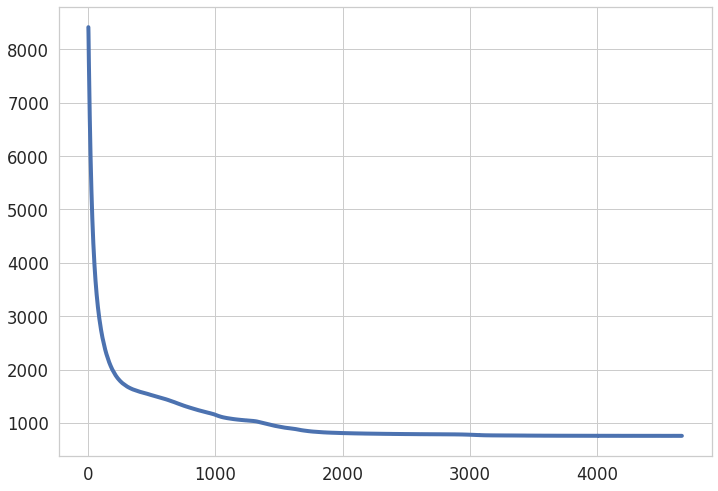

<IPython.core.display.Javascript object>

In [16]:
# plot the ELBO across iterations
plt.plot(loss_history)

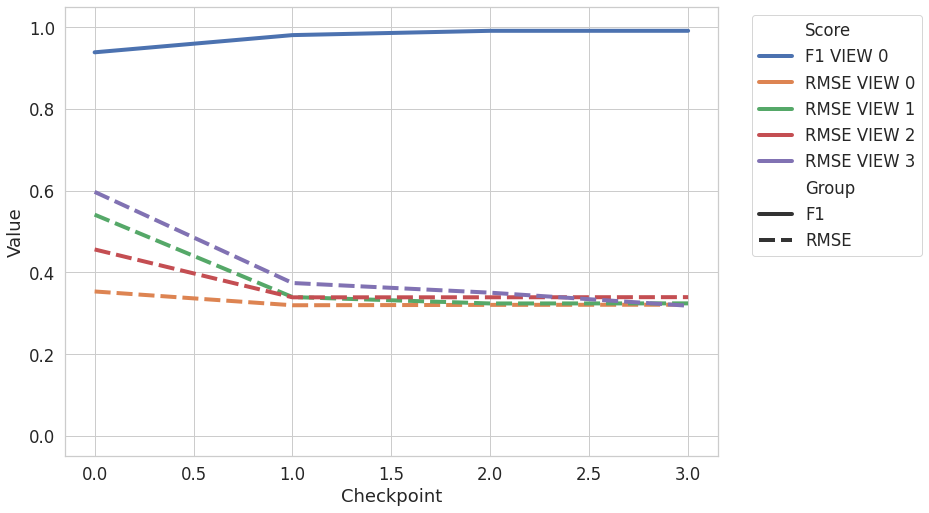

<IPython.core.display.Javascript object>

In [17]:
df = pd.DataFrame(log_callback.scores)
df["checkpoint"] = df.index
df = pd.melt(df, id_vars=["checkpoint"], value_vars=df.columns[:-1])
df.columns = ["Checkpoint", "Score", "Value"]
df["Score"] = df["Score"].map(lambda s: " ".join([p.upper() for p in s.split("_")]))
df["Group"] = df["Score"].str.split(" ").str[0]


g = sns.lineplot(
    data=df[df["Score"].str.contains("RMSE|F1")],
    x="Checkpoint",
    y="Value",
    hue="Score",
    style="Group",
)
g.set(ylim=(-0.05, 1.05))
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

Once the training converges, we may inspect the learned parameters and compare them to the true parameters.

<AxesSubplot:>

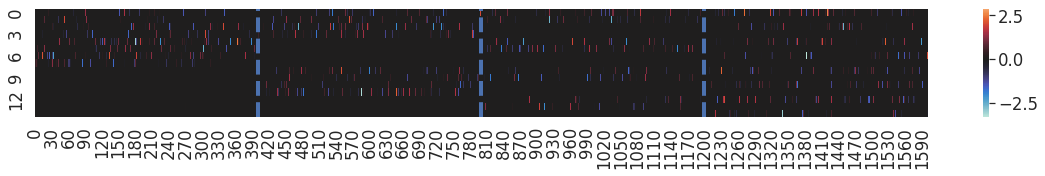

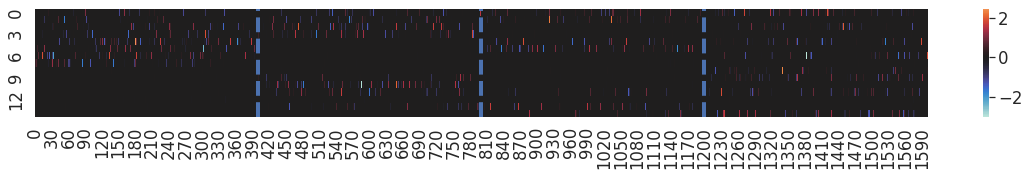

<IPython.core.display.Javascript object>

In [18]:
approx_ws = [model.get_factor_loadings()[vn] for vn in model.view_names]
approx_w = np.concatenate(approx_ws, axis=1)

muvi.pl.lined_heatmap(dg.w, vlines=vlines, center=0)
muvi.pl.lined_heatmap(approx_w, vlines=vlines, center=0)

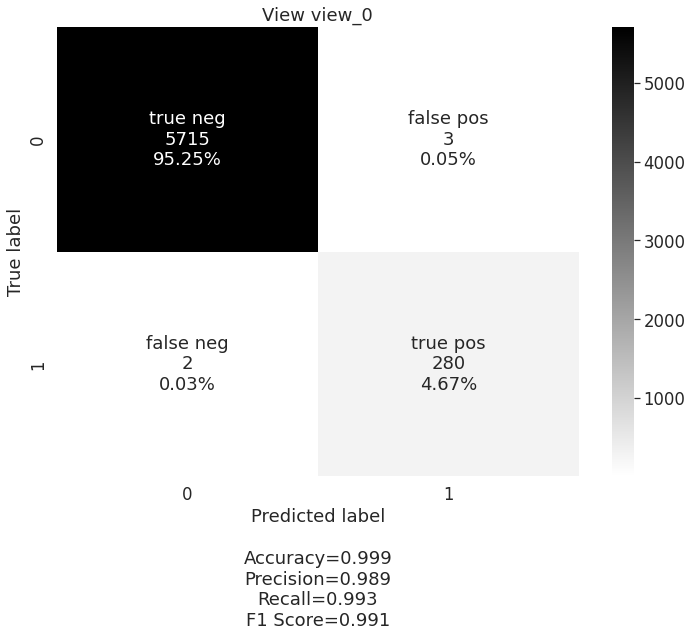

<IPython.core.display.Javascript object>

In [19]:
threshold = 0.1
# plot the confusion matrix between the true loadings activity and the learned loadings activity for the informed views
for m in informed_views:
    _ = muvi.pl.confusion_matrix(model, model.view_names[m], true_mask=dg.w_masks[m])
    plt.show()

Due to non-identifiability of FA models, it is sometimes necessary to permute the order of the factors match the true order. We do so by first computing the cosine similarities between the true factor loadings mask and the learned factor loading activations (based on a threshold). Then, we find the optimal permutation by matching each factor with its corresponding true factor index based on the largest cosine similarity.

<AxesSubplot:>

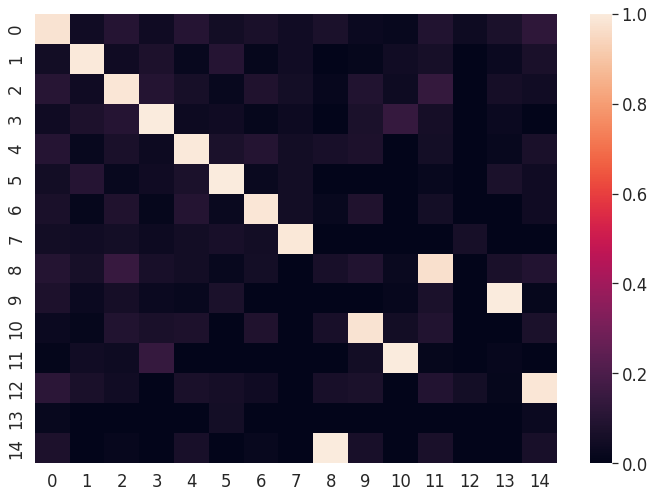

<IPython.core.display.Javascript object>

In [20]:
cos_sim = cosine_similarity(dg.w_mask, np.abs(approx_w) > threshold)
sns.heatmap(cos_sim, annot=False)

/home/aqoku/projects/muvi/muvi/tools/utils.py:541: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res = linprog(


<AxesSubplot:>

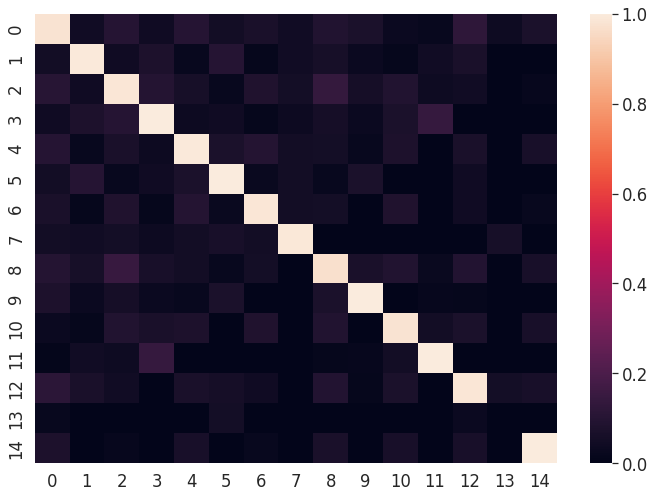

<IPython.core.display.Javascript object>

In [21]:
opt_order = muvi.tl.optim_perm(cos_sim).argmax(axis=0)
sns.heatmap(cos_sim[:, opt_order], annot=False)

Our model also infers the relationship across subsets of views by learning a set of `factor_scales` for each view. The lower the value of a factor scale $k$ in view $m$, the less significant this factor is for view $m$.

In [22]:
factor_scales = model._guide.get_factor_scale()[:, opt_order]
factor_scales = factor_scales / np.max(factor_scales, axis=1)[:, None]

<IPython.core.display.Javascript object>

<AxesSubplot:>

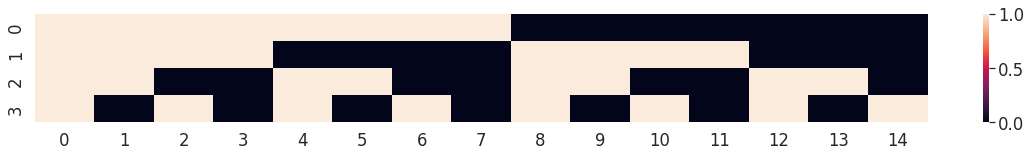

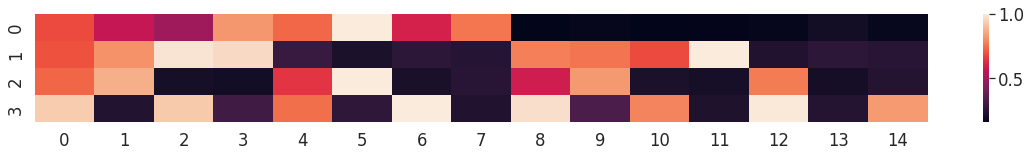

<IPython.core.display.Javascript object>

In [23]:
muvi.pl.lined_heatmap(dg.view_factor_mask)
muvi.pl.lined_heatmap(factor_scales)

We can also go one level deeper and inspect a single factors by extractin its factor loadings and plotting the sorted weights along with their corresponding state, one of true positive (TP), true negative (TN), false positive (FP) and false negative (FN). Ideally we would like to see true active loadings away from zero, i.e. true positives (TP), false negatives (FN), and true inactive loadings close to zero, i.e. false positives (FP), true negatives (TN)

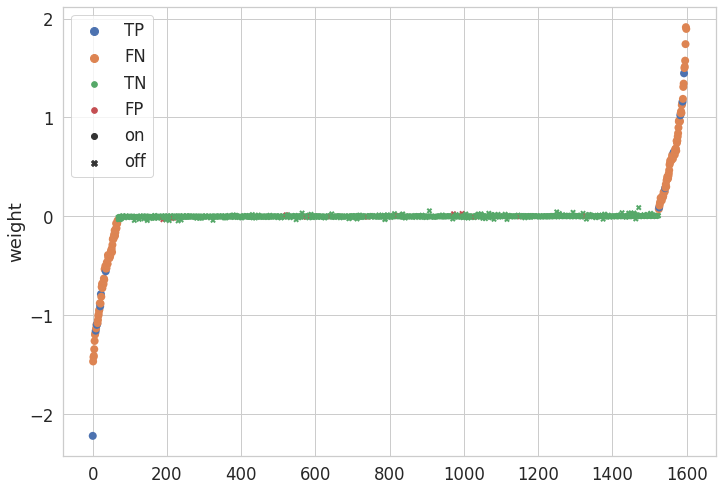

<IPython.core.display.Javascript object>

In [24]:
g, _ = muvi.pl.factor_activity(
    dg.w, approx_w[opt_order, :], dg.w_mask, dg.noisy_w_mask, factor_idx=0
)